# Make N(z) file for computing cosmic variance from PKDGRAV sims.

In [ ]:
import numpy as np

In [ ]:
flask1 = open('/global/project/projectdirs/des/mgatti/Moments_analysis/Nz/FLASK_1.txt','r')
z_bin = flask1.read().split('\n')[:-1][2:]
z = [float(n.split(' ')[0]) for n in z_bin]

In [ ]:
len(z_bin)

In [ ]:
nontomo = np.zeros(300, dtype=[('z', 'f8'), ('nz', 'f8')])
nontomo['z'] = z
for i in range(4):
    flask = open('/global/project/projectdirs/des/mgatti/Moments_analysis/Nz/FLASK_'+str(i+1)+'.txt','r')
    z_bin = flask.read().split('\n')[:-1][2:]
    nz = np.array([float(n.split(' ')[1]) for n in z_bin]) / 4
    nontomo['nz'] += nz

In [ ]:
new_f = open('/global/cscratch1/sd/myamamot/sample_variance/Y3_nontomographic_nz.txt', 'w')
for z,nz in zip(nontomo['z'], nontomo['nz']):
    new_f.write(str(z))
    new_f.write(' ')
    new_f.write(str(nz))
    new_f.write('\n')
new_f.close()

# Check mcal catalog which was used to compute the variance.

In [ ]:
import pickle
with open('/project/projectdirs/des/mass_maps/Maps_final/data_catalogs_weighted.pkl','rb') as f:
    d = pickle.load(f)

In [ ]:
len(d[0]['e1'])

# Make mdet catalog that can be used to compute the variance.

In [1]:
import pickle
with open('/global/cscratch1/sd/myamamot/metadetect/inverse_variance_weight_v2_Trcut.pickle', 'rb') as handle:
    res = pickle.load(handle)

In [2]:
s2n = res['xedges']
Tratio = res['yedges']
shear_weight = res['weight']
shear_response = res['response']

In [3]:
import fitsio as fio
import glob
mdet_f = glob.glob('/global/cscratch1/sd/myamamot/metadetect/cuts_v2/*_metadetect-v5_mdetcat_part0000.fits')

def _compute_shear(d):
    
    msk_1p = (d["mdet_step"] == "1p")
    g1p = np.mean(d[msk_1p]["mdet_g_1"])

    msk_1m = (d["mdet_step"] == "1m")
    g1m = np.mean(d[msk_1m]["mdet_g_1"])
    
    R11 = (g1p - g1m) / 0.02
    
    msk_2p = (d["mdet_step"] == "2p")
    g2p = np.mean(d[msk_2p]["mdet_g_2"])

    msk_2m = (d["mdet_step"] == "2m")
    g2m = np.mean(d[msk_2m]["mdet_g_2"])
    
    R22 = (g2p - g2m) / 0.02
    
    # Mean shear
    msk_noshear = (d["mdet_step"] == "noshear")
    g1 = np.mean(d[msk_noshear]["mdet_g_1"] / R11)
    g2 = np.mean(d[msk_noshear]["mdet_g_2"] / R22)
    
    return g1, g2, R11, R22

def assign_loggrid(x, y, xmin, xmax, xsteps, ymin, ymax, ysteps):
    from math import log10
    # return x and y indices of data (x,y) on a log-spaced grid that runs from [xy]min to [xy]max in [xy]steps

    logstepx = log10(xmax/xmin)/xsteps
    logstepy = log10(ymax/ymin)/ysteps

    indexx = (np.log10(x/xmin)/logstepx).astype(int)
    indexy = (np.log10(y/ymin)/logstepy).astype(int)

    indexx = np.maximum(indexx,0)
    indexx = np.minimum(indexx, xsteps-1)
    indexy = np.maximum(indexy,0)
    indexy = np.minimum(indexy, ysteps-1)

    return indexx,indexy

def _find_shear_weight(d, snmin, snmax, sizemin, sizemax, steps):
    
    indexx, indexy = assign_loggrid(d['mdet_s2n'], d['mdet_T_ratio'], snmin, snmax, steps, sizemin, sizemax, steps)
    weight = [shear_weight[x, y] for x, y in zip(indexx, indexy)]
    response = [shear_response[x, y] for x, y in zip(indexx, indexy)]
    
    return np.array(weight), np.array(response)

In [4]:
snmin=10
snmax=300
sizemin=0.5
sizemax=3
steps=20

In [5]:
from tqdm import tqdm
import numpy as np

mdet_dict = {0: {}}
for i, fname in tqdm(enumerate(mdet_f)):
    
    d = fio.read(fname)
    msk_noshear = (d['mdet_step'] == 'noshear')
    
    w_shear, r_shear = _find_shear_weight(d, snmin, snmax, sizemin, sizemax, steps)
    g1 = d[msk_noshear]['mdet_g_1']/r_shear[msk_noshear]
    g2 = d[msk_noshear]['mdet_g_2']/r_shear[msk_noshear]

    if i == 0:
        mdet_dict[0]['ra'] = d[msk_noshear]['ra']
        mdet_dict[0]['dec'] = d[msk_noshear]['dec']
        mdet_dict[0]['e1'] = g1
        mdet_dict[0]['e2'] = g2
        mdet_dict[0]['w'] = w_shear[msk_noshear]
    else:
        mdet_dict[0]['ra'] = np.append(mdet_dict[0]['ra'], d[msk_noshear]['ra'])
        mdet_dict[0]['dec'] = np.append(mdet_dict[0]['dec'], d[msk_noshear]['dec'])
        mdet_dict[0]['e1'] = np.append(mdet_dict[0]['e1'], g1)
        mdet_dict[0]['e2'] = np.append(mdet_dict[0]['e2'], g2)
        mdet_dict[0]['w'] = np.append(mdet_dict[0]['w'], w_shear[msk_noshear])

5679it [2:43:26,  1.73s/it]


In [6]:
len(mdet_dict[0]['ra'])

94120339

In [7]:
with open('/global/cscratch1/sd/myamamot/sample_variance/data_catalogs_weighted.pkl', 'wb') as handle:
    pickle.dump(mdet_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# How to run the simulations

# Output of the simulation

In [7]:
import pickle
import proplot as pplt
import numpy as np
import matplotlib as mpl
import glob
%matplotlib inline
nsims = 200

# data
with open('/global/cscratch1/sd/myamamot/sample_variance/data_catalogs_weighted.pkl', 'rb') as handle:
    res_data = pickle.load(handle)
# sim files
res_sim_files = glob.glob('/global/cscratch1/sd/myamamot/sample_variance/seed__fid_*.pkl')

-1.922381224794518e-05 1.0171325543857221
-0.00021549796205765412 1.0051945264810596


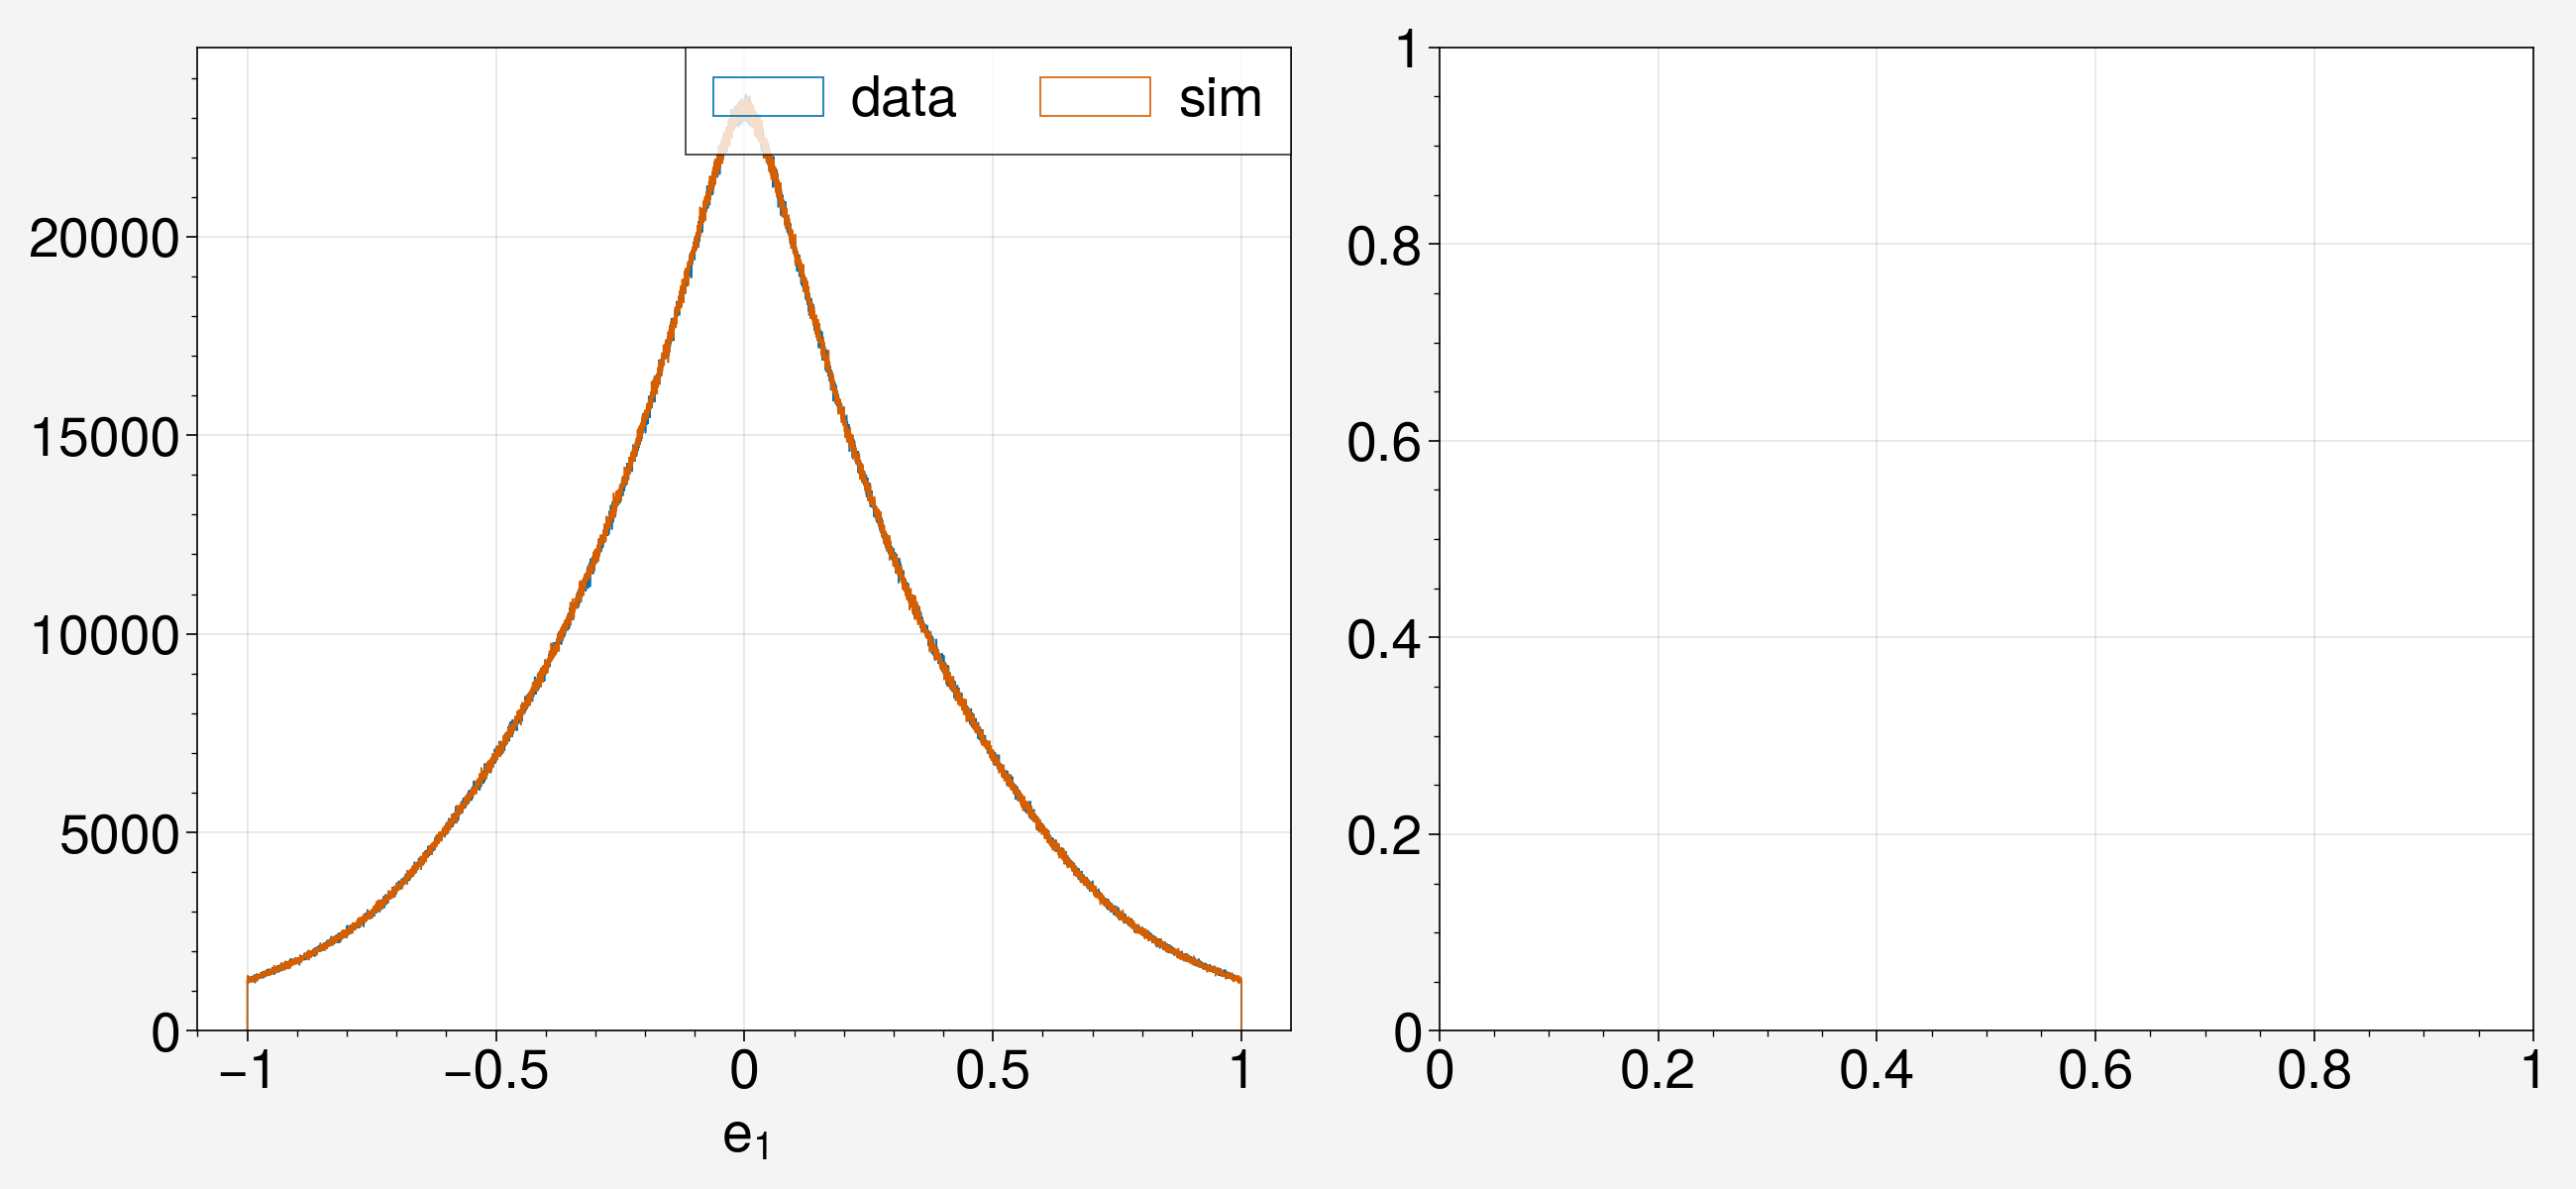

In [19]:
mpl.rcParams.update({'font.size':20})
fig, axs = pplt.subplots(nrows=1, ncols=2, figsize=(13,6), sharey=False, sharex=False)

for n,fname in enumerate(res_sim_files[:1]):
    with open(fname, 'rb') as handle:
        res_sim = pickle.load(handle)
    handle.close()
    
    print(np.mean(res_data[0]['e1']), np.std(res_data[0]['e1']))
    print(np.mean(res_sim['sources'][0]['e1']), np.std(res_sim['sources'][0]['e1']))
    
    axs[0].hist(res_data[0]['e1'], bins=10000, range=(-1,1), histtype='step', label='data')
    axs[0].hist(res_sim['sources'][0]['e1'], bins=10000, range=(-1,1), histtype='step', label='sim')
    axs[0].set_xlabel(r'$e_{1}$')
    axs[0].legend(loc='upper right')